In [25]:
%matplotlib inline

# To show model architecture, might need to install these
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz
from tensorflow.keras.utils import plot_model

from typing import Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras, config
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

gpus = config.experimental.list_physical_devices('GPU')
config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 16 = 16GB

from cascid.datasets.pad_ufes.database import get_df, get_train_test_images_raw
from cascid.configs.config import DATA_DIR

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [3]:
df = get_df()
df

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,CHEST,13.0,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOREARM,NaN,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,True,False,False,3.0,FACE,5.0,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


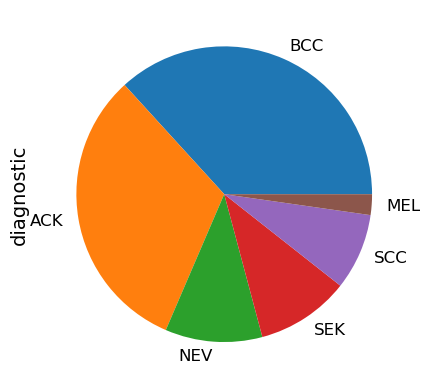

In [4]:
df["diagnostic"].value_counts().plot.pie();

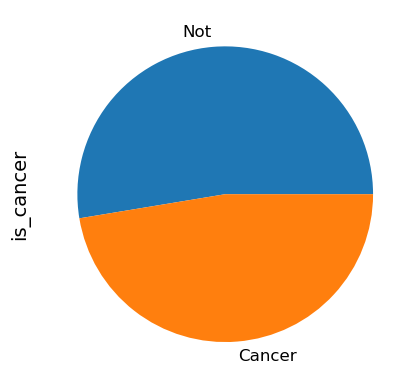

In [5]:
df['is_cancer'] = df['diagnostic'].apply(lambda s: "Cancer" if s in ["MEL", "BCC", "SCC"] else "Not")
df["is_cancer"].value_counts().plot.pie();

In [6]:
x_train, x_test, y_train, y_test = get_train_test_images_raw()

In [7]:
MulticlassEnconder = OneHotEncoder(sparse=False)
BinaryClassEnconder = OneHotEncoder(sparse=False)
Y = MulticlassEnconder.fit_transform(y_train)
Y_binary = BinaryClassEnconder.fit_transform(np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_train))).reshape(-1,1))

In [9]:
model = load_model(DATA_DIR / 'cnn' / 'pad_ufes')

2022-11-25 10:45:28.489368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 10:45:28.490019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:45:28.491327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:45:28.491895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

2022-11-25 10:45:55.789642: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 361365504 exceeds 10% of free system memory.
2022-11-25 10:45:56.177975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 361365504 exceeds 10% of free system memory.
2022-11-25 10:45:57.105587: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-25 10:45:57.636899: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 7/15 [=============>................] - ETA: 0s

2022-11-25 10:45:59.155857: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 90439680 exceeds 10% of free system memory.
2022-11-25 10:45:59.266593: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 90439680 exceeds 10% of free system memory.


15/15 [==============================] - 0s 17ms/step


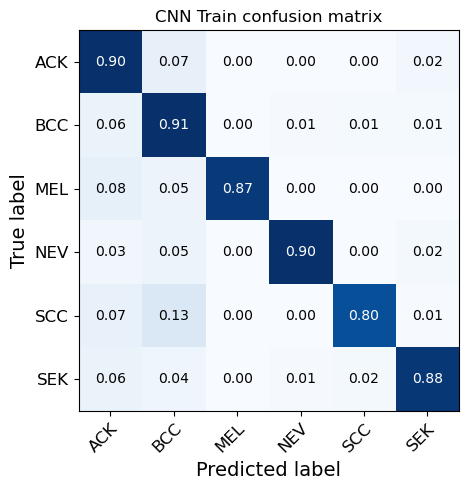

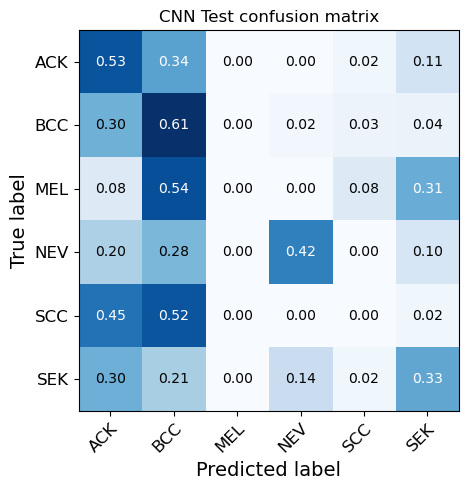

<Figure size 1000x500 with 0 Axes>

In [24]:
y_pred_classes = MulticlassEnconder.inverse_transform(y_pred_train).flatten()
y_true = y_train.flatten()
ax = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="CNN Train confusion matrix")
y_pred_classes = MulticlassEnconder.inverse_transform(y_pred_test).flatten()
y_true = y_test.flatten()
ax2 = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="CNN Test confusion matrix")
fig = plt.figure(figsize=(10,5))
fig.axes.append(ax)
fig.axes.append(ax2)
fig.show();

In [26]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

         ACK       0.42      0.53      0.47       133
         BCC       0.52      0.61      0.56       177
         MEL       0.00      0.00      0.00        13
         NEV       0.70      0.42      0.53        50
         SCC       0.00      0.00      0.00        44
         SEK       0.30      0.33      0.31        43

    accuracy                           0.46       460
   macro avg       0.32      0.31      0.31       460
weighted avg       0.43      0.46      0.44       460



/home/dell/anaconda3/envs/dell/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell/anaconda3/envs/dell/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell/anaconda3/envs/dell/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

      Cancer       0.60      0.55      0.57       234
         Not       0.57      0.62      0.60       226

    accuracy                           0.58       460
   macro avg       0.59      0.59      0.58       460
weighted avg       0.59      0.58      0.58       460



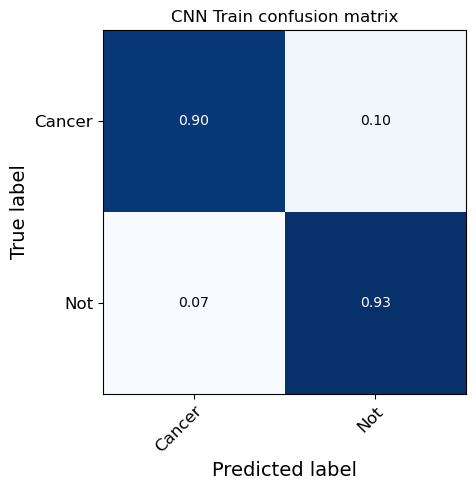

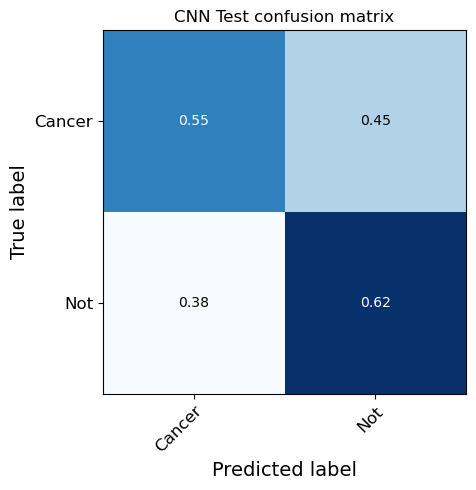

<Figure size 1000x500 with 0 Axes>

In [39]:
cnn_bin = load_model(DATA_DIR / 'cnn_bin' / 'pad_ufes')
y_pred_train = cnn_bin.predict(x_train)
y_pred_test = cnn_bin.predict(x_test)
y_pred_classes = BinaryClassEnconder.inverse_transform(y_pred_train).flatten()
y_true = list(map(lambda x : "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", y_train.flatten()))
ax = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="CNN Train confusion matrix")
y_pred_classes = BinaryClassEnconder.inverse_transform(y_pred_test).flatten()
y_true = list(map(lambda x : "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", y_test.flatten()))
ax2 = plot_confusion_matrix(y_true=y_true, y_pred=y_pred_classes, classes=sorted(list(set(y_true))), cmap="Blues", title="CNN Test confusion matrix")
fig = plt.figure(figsize=(10,5))
fig.axes.append(ax)
fig.axes.append(ax2)
fig.show();
print(classification_report(y_true, y_pred_classes))

(1838, 256, 256, 3)